In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import natsort
import numpy as np
import pandas as pd
import seaborn as sns
from natsort import index_natsorted

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
ROOT: Path = Path(
    "/Volumes/carlos/MedUni and LBIAD Computing Server/phd_data/PCTA_WCDT_GSE221601_FILTERED"
)
FIGURES_PATH: Path = ROOT.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

## WGCNA

---


Setup

In [5]:
WGCNA_EXP_NAMES: Dict[str, str] = {
    "prim vs norm": "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0",
    "mHSPC vs prim": "sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0",
    "mCRPC vs mHSPC": "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0",
}

In [6]:
def prepare_wgcna_data_for_plotting(
    wgcna_exp_name: str,
) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """
    Loads and prepares WGCNA data for a given experiment for plotting.

    Args:
        wgcna_exp_name (str): Name of the WGCNA experiment.

    Returns:
        Tuple[pd.DataFrame, Dict[str, str]]:
            - network_genes_df: DataFrame with network gene information (module, log2FoldChange).
            - mod_hub_genes: Dictionary of module hub genes.
    """
    # 1. Load hub genes data
    hub_genes_df = pd.read_csv(
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_hub_genes.csv"),
        index_col=0,
    )

    # 2. Create dictionary of module hub genes, excluding M0
    mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
    if "M0" in mod_hub_genes:
        del mod_hub_genes["M0"]

    # 3. Load network genes data and filter out M0
    network_genes_df = pd.read_csv(
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_network_genes.csv"),
        index_col="SYMBOL",
    )
    network_genes_df = network_genes_df.loc[network_genes_df["module"] != "M0"]

    if network_genes_df.empty:
        # Return empty structures if no relevant modules
        return pd.DataFrame(), {}

    # Sort modules naturally for consistent plotting order
    unique_modules_in_exp = network_genes_df["module"].unique()
    module_order = natsort.natsorted(
        unique_modules_in_exp.tolist()
        if hasattr(unique_modules_in_exp, "tolist")
        else list(unique_modules_in_exp)
    )
    network_genes_df["module"] = pd.Categorical(
        network_genes_df["module"], categories=module_order, ordered=True
    )
    network_genes_df = network_genes_df.sort_values("module")

    return network_genes_df, mod_hub_genes

In [7]:
def combined_wgcna_violinplot(  # Renamed function
    wgcna_exp_names: Dict[str, str],
    figure_path: Path,
) -> None:
    """
    Creates a combined violin plot showing the distribution of log2 fold change values
    across WGCNA modules for multiple experiments, arranged horizontally.
    Hub genes are indicated in the x-axis tick labels.

    Args:
        wgcna_exp_names (Dict[str, str]): Dictionary of WGCNA experiment names (key: title, value: folder name).
        figure_path (Path): Path to save the figure.
    """
    num_experiments = len(wgcna_exp_names)

    experiment_data = []
    for exp_key, exp_name in wgcna_exp_names.items():
        network_df, mod_hub_genes = prepare_wgcna_data_for_plotting(exp_name)

        if not network_df.empty:
            # Filter out log2FoldChange values > 6
            network_df = network_df[network_df["log2FoldChange"] <= 6]
            if not network_df.empty:  # Check if df is empty after filtering
                experiment_data.append(
                    {
                        "key": exp_key,
                        "name": exp_name,
                        "network_df": network_df,
                        "mod_hub_genes": mod_hub_genes,
                        "num_modules": network_df["module"].nunique(),
                    }
                )
            else:  # If filtering made it empty
                experiment_data.append(
                    {
                        "key": exp_key,
                        "name": exp_name,
                        "network_df": pd.DataFrame(),
                        "mod_hub_genes": {},
                        "num_modules": 0,
                    }
                )
        else:
            experiment_data.append(
                {
                    "key": exp_key,
                    "name": exp_name,
                    "network_df": pd.DataFrame(),
                    "mod_hub_genes": {},
                    "num_modules": 0,
                }
            )

    if not any(exp["num_modules"] > 0 for exp in experiment_data):
        print("No data to plot across all experiments after filtering.")
        return

    width_ratios = [max(1, exp["num_modules"]) for exp in experiment_data]
    total_module_units = sum(width_ratios)

    base_module_width = 0.7  # Adjusted for potentially wider violins
    inter_experiment_spacing = 1
    fig_width = (
        total_module_units * base_module_width
        + (num_experiments - 1) * inter_experiment_spacing
        + 2
    )
    fig_width = max(12, fig_width)
    fig_height = 7  # Keep height as previously adjusted

    fig, axes = plt.subplots(
        1,
        num_experiments,
        figsize=(fig_width, fig_height),
        sharey=True,
        gridspec_kw={"width_ratios": width_ratios, "wspace": 0.05},
        constrained_layout=True,  # Use constrained_layout
    )

    if num_experiments == 1:
        axes = [axes]

    all_modules_across_experiments = set()
    for exp_data in experiment_data:
        if not exp_data["network_df"].empty:
            all_modules_across_experiments.update(
                exp_data["network_df"]["module"].unique()
            )

    sorted_unique_modules = natsort.natsorted(list(all_modules_across_experiments))
    palette = sns.color_palette("Spectral", len(sorted_unique_modules))
    module_colors = {
        module: color for module, color in zip(sorted_unique_modules, palette)
    }

    for i, exp_data in enumerate(experiment_data):
        ax = axes[i]
        exp_key = exp_data["key"]
        network_genes_df = exp_data["network_df"]
        mod_hub_genes = exp_data["mod_hub_genes"]

        if network_genes_df.empty:
            ax.text(
                0.5,
                0.5,
                "No modules",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=10,
                color="grey",
            )
            ax.set_title(f"{exp_key.replace('_vs_', ' vs ')}", fontsize=12, pad=15)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            continue

        current_module_order = natsort.natsorted(
            network_genes_df["module"].unique().tolist()
        )

        # Changed from violinplot to boxplot
        sns.boxplot(
            data=network_genes_df,
            x="module",
            y="log2FoldChange",
            order=current_module_order,
            hue="module",  # Kept for consistency, colors boxes by module
            hue_order=current_module_order,
            palette=[
                module_colors.get(mod, "lightgrey") for mod in current_module_order
            ],
            ax=ax,
            dodge=False,  # No dodging needed as x is already module
            linewidth=0.75,
            showfliers=False,  # Hide outlier markers
        )

        sns.stripplot(
            data=network_genes_df,
            x="module",
            y="log2FoldChange",
            order=current_module_order,
            hue="module",  # Keep hue for consistency, though it might be redundant with boxplot colors
            hue_order=current_module_order,
            palette=[
                module_colors.get(mod, "lightgrey") for mod in current_module_order
            ],
            dodge=False,
            jitter=0.15,  # Adjusted jitter for box plots
            ax=ax,
            s=2.0,  # Slightly smaller points
            alpha=0.5,  # Slightly more transparent points
        )

        ax.set_xlabel("", fontsize=11)
        if i == 0:
            ax.set_ylabel("Log₂ Fold Change", fontsize=14, labelpad=10)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis="y", which="both", left=False)

        module_counts = (
            network_genes_df["module"].value_counts().reindex(current_module_order)
        )

        xtick_labels = []
        for mod in current_module_order:
            hub_gene = mod_hub_genes.get(mod, "N/A")
            # Removed leading/trailing newlines from rf-string
            xtick_labels.append(
                rf"""$\mathbf{{{mod}}}$
$(\mathit{{{hub_gene.replace("_", "\\_")}}})$"""
            )

        ax.set_xticks(np.arange(len(current_module_order)))
        ax.set_xticklabels(
            xtick_labels, fontsize=13, rotation=0, ha="center"
        )  # Increased fontsize to 11
        ax.tick_params(axis="x", which="major", pad=8)
        ax.tick_params(axis="y", labelsize=10)

        y_annotation_level = 0.75
        for idx, mod in enumerate(current_module_order):
            count = module_counts.get(mod, 0)
            ax.text(
                idx,
                y_annotation_level,
                f"(n={count})",
                ha="center",
                va="center",
                fontsize=11,  # Increased fontsize to 9
                transform=ax.transData,
            )

        ax.set_title(
            f"{exp_key.replace('_vs_', ' vs ')}", fontsize=18, pad=15, fontweight="bold"
        )
        ax.grid(axis="y", linestyle=":", alpha=0.6, zorder=-10, color="gray")
        ax.legend([], [], frameon=False)

        ax.set_ylim(
            bottom=0.5,
            top=6,
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)

    fig.suptitle(
        "WGCNA Module LFC Distributions (Up-regulated DEGs)",
        fontsize=16,
        y=1.05,  # y may need adjustment with constrained_layout
        fontweight="bold",
    )
    # Removed fig.tight_layout() as constrained_layout=True is used

    figure_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(
        figure_path.joinpath(
            "combined_wgcna_violinplot_horizontal.pdf"  # Consider renaming if it's now boxplot
        ),
        bbox_inches="tight",
    )
    plt.savefig(
        figure_path.joinpath(
            "combined_wgcna_violinplot_horizontal.png"  # Consider renaming
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

Violin plots

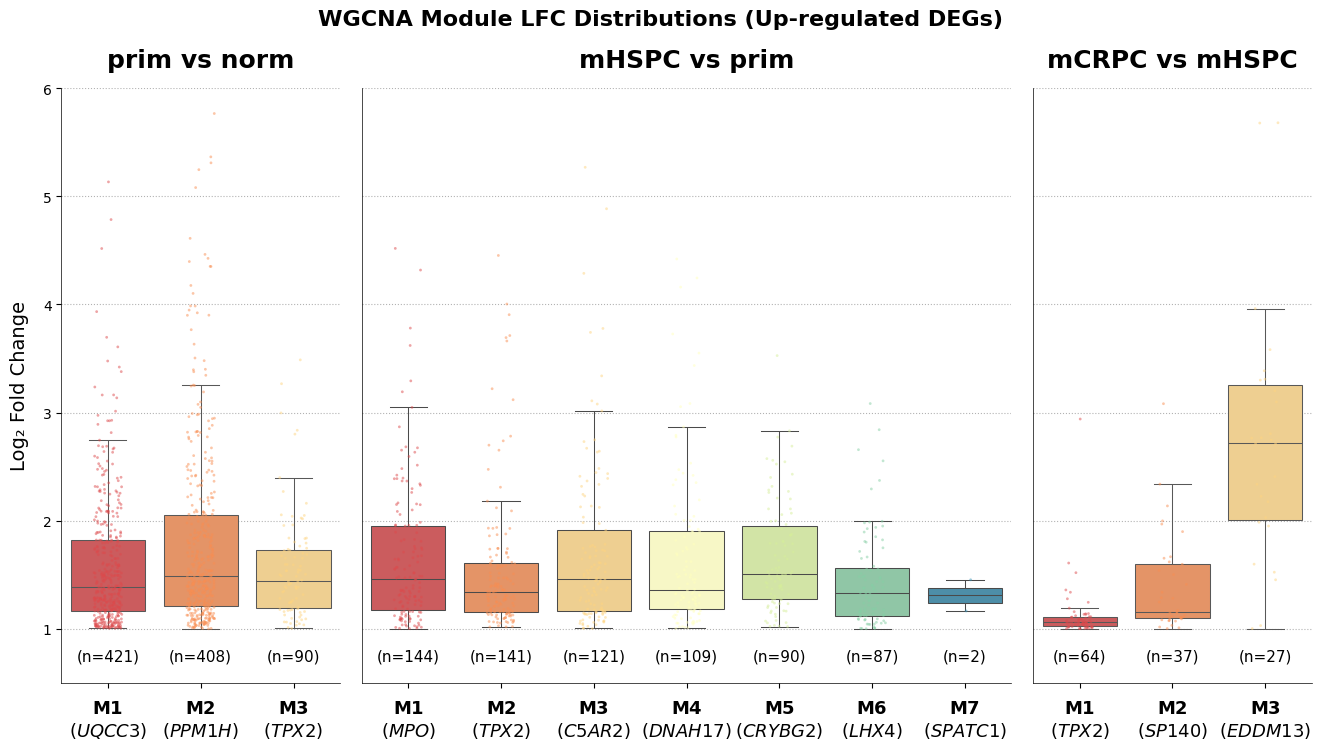

In [8]:
# Call the new combined plotting function
combined_wgcna_violinplot(
    wgcna_exp_names=WGCNA_EXP_NAMES, figure_path=FIGURES_PATH
)  # Renamed function call

## Additional files for WGCNA and ML analyses

---


In [9]:
SUPPLEMENTARY_FILES_PATH: Path = ROOT.joinpath("supplementary_files")
SUPPLEMENTARY_FILES_PATH.mkdir(parents=True, exist_ok=True)

### WGCNA DEGs

In [10]:
contrast_pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
level_pattern = r"(all|up|down)"

In [11]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")
supplementary_file_wgcna = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_wgcna_degs.xlsx"),
    engine="openpyxl",
)

In [12]:
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("*standard/results/bicor_signed_network_genes.csv"))
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))

    if not contrast_match or not level_match:
        print(f"Skipping {wgcna_contrast_file} due to no match.")
        continue

    contrast = contrast_match.group(0)
    level = level_match.group(0)

    if level == "all":
        continue

    pd.read_csv(wgcna_contrast_file, index_col=0).sort_values("module").to_excel(
        supplementary_file_wgcna, sheet_name=f"{contrast}_{level}"
    )

In [13]:
supplementary_file_wgcna.close()

### WGCNA Pathways

In [14]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")
supplementary_file_wgcna = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_wgcna_pathways.xlsx"),
    engine="openpyxl",
)

In [15]:
wgcna_modules_pathways = defaultdict(dict)
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("*standard/functional/REACTOME/bicor_signed_M*_ora.csv"))
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))
    module_id_match = re.search(r"M\d", wgcna_contrast_file.name)

    if not contrast_match or not level_match or not module_id_match:
        continue

    contrast = contrast_match.group(0)
    level = level_match.group(0)

    if level == "all":
        continue

    module_id = module_id_match.group(0)

    if module_id == "M0":
        continue

    wgcna_modules_pathways[(contrast, level)][module_id] = pd.read_csv(
        wgcna_contrast_file, index_col=0
    )

for (contrast, level), modules in wgcna_modules_pathways.items():
    contrast_pathways = []
    for module_id, pathways in modules.items():
        pathways["module"] = module_id
        contrast_pathways.append(pathways)

    if contrast_pathways:
        pd.concat(contrast_pathways).to_excel(
            supplementary_file_wgcna, sheet_name=f"{contrast}_{level}_reactome"
        )

In [16]:
supplementary_file_wgcna.close()

### ML

In [17]:
ML_ROOT: Path = ROOT.joinpath("ml_classifiers")
supplementary_file_ml = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_ml.xlsx"),
    engine="openpyxl",
)

First-order SHAP values

In [18]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_values.csv"))
):
    match = re.search(pattern, contrast_shap_values_file.parents[3].name)
    if match:
        sheet_name = match.group(0) + "_shap"
        pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
            supplementary_file_ml, sheet_name=sheet_name
        )

Second-order SHAP values

In [19]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_interaction_summary.csv"))
):
    sheet_name = (
        re.search(pattern, contrast_shap_values_file.parents[3].name).group(0)
        + "_interactions"
    )
    pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
        supplementary_file_ml, sheet_name=sheet_name
    )

In [20]:
supplementary_file_ml.close()

## WGCNA Summary Table

---


In [21]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")

In [25]:
wgcna_summary: Dict = {}
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("*standard/results/bicor_signed_network_genes.csv"))
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))

    if not contrast_match or not level_match:
        print(f"Skipping {wgcna_contrast_file} due to no match.")
        continue

    contrast = contrast_match.group(0).replace("_vs_", "/")
    level = level_match.group(0)
    print(f"Processing contrast: {contrast}, level: {level}")

    if level == "all":
        print(f"Skipping level 'all' for {wgcna_contrast_file}")
        continue

    module_counts = (
        pd.read_csv(wgcna_contrast_file, index_col=0)
        .groupby("module")
        .count()
        .iloc[:, 0]
        .to_dict()
    )
    hub_genes_path = wgcna_contrast_file.parent / "bicor_signed_hub_genes.csv"

    if not hub_genes_path.exists():
        print(f"Hub genes file not found for {wgcna_contrast_file}, skipping.")
        continue
    print(f"Loaded hub genes for {contrast}, {level}")

    hub_genes = pd.read_csv(hub_genes_path, index_col=0)

    modules_meta = {}
    module_degs_cum = 0
    module_pathways_cum = 0
    for module_id, module_degs in module_counts.items():
        if module_id == "M0":
            print(f"Skipping module M0 for {contrast}, {level}")
            continue
        print(f"  Processing module: {module_id} ({module_degs} genes)")

        pathway_file_path = (
            wgcna_contrast_file.parents[1]
            / "functional"
            / "REACTOME"
            / f"bicor_signed_{module_id}_ora.csv"
        )

        if pathway_file_path.exists():
            module_pathways = len(pd.read_csv(pathway_file_path, index_col=0))
            print(
                f"    Found {module_pathways} enriched pathways for module {module_id}"
            )

        else:
            module_pathways = 0
            print(f"    No enriched pathways found for module {module_id}")

        if module_id not in hub_genes.index:
            print(
                f"    Hub gene not found for module {module_id} in {wgcna_contrast_file}, skipping module."
            )
            continue

        hub_gene = hub_genes.loc[module_id, "SYMBOL"]
        modules_meta[module_id] = (
            f"{hub_gene} ({module_degs} module genes, {module_pathways} enriched pathways)"
        )
        module_degs_cum += module_degs
        module_pathways_cum += module_pathways

    if module_degs_cum > 0:
        modules_meta["Total"] = (
            f"({module_degs_cum} module genes, {module_pathways_cum} enriched pathways)"
        )
        print(
            f"  Total for {contrast}, {level}: {module_degs_cum} module genes, {module_pathways_cum} enriched pathways"
        )

    if modules_meta:
        wgcna_summary[(contrast, level)] = modules_meta

wgcna_summary_df = pd.DataFrame(wgcna_summary).fillna("")
wgcna_summary_df = wgcna_summary_df.iloc[index_natsorted(wgcna_summary_df.index)]
wgcna_summary_df = wgcna_summary_df.reindex(
    columns=pd.MultiIndex.from_tuples(
        [
            ("prim/norm", "up"),
            ("prim/norm", "down"),
            ("hspc/prim", "up"),
            ("hspc/prim", "down"),
            ("mcrpc/hspc", "up"),
            ("mcrpc/hspc", "down"),
        ]
    )
).fillna("")
wgcna_summary_df.to_excel(
    SUPPLEMENTARY_FILES_PATH.joinpath("wgcna_summary_table.xlsx"),
    sheet_name="WGCNA_summary",
)

wgcna_summary_df

Processing contrast: hspc/prim, level: all
Skipping level 'all' for /Volumes/carlos/MedUni and LBIAD Computing Server/phd_data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_all_1_0/standard/results/bicor_signed_network_genes.csv
Processing contrast: hspc/prim, level: down
Loaded hub genes for hspc/prim, down
Skipping module M0 for hspc/prim, down
  Processing module: M1 (168 genes)
    No enriched pathways found for module M1
  Processing module: M2 (166 genes)
    No enriched pathways found for module M2
  Processing module: M3 (92 genes)
    No enriched pathways found for module M3
  Processing module: M4 (75 genes)
    No enriched pathways found for module M4
  Processing module: M5 (61 genes)
    No enriched pathways found for module M5
  Processing module: M6 (58 genes)
    No enriched pathways found for module M6
  Processing module: M7 (49 genes)
    No enriched pathways found for module M7
  Processing module: M8 (29 genes)
    Foun

prim/norm  \
                                                   up   
M1     UQCC3 (422 module genes, 35 enriched pathways)   
M2      PPM1H (408 module genes, 0 enriched pathways)   
M3       TPX2 (90 module genes, 24 enriched pathways)   
M4                                                      
M5                                                      
M6                                                      
M7                                                      
M8                                                      
M9                                                      
Total        (920 module genes, 59 enriched pathways)   

                                                        \
                                                  down   
M1     ADAM33 (2238 module genes, 3 enriched pathways)   
M2                                                       
M3                                                       
M4                                                       
M5                                                       
M6                                                       
M7                                                       
M8                                                       
M9                                                       
Total         (2238 module genes, 3 enriched pathways)   

                                            hspc/prim  \
                                                   up   
M1        MPO (144 module genes, 1 enriched pathways)   
M2      TPX2 (141 module genes, 58 enriched pathways)   
M3      C5AR2 (121 module genes, 3 enriched pathways)   
M4     DNAH17 (109 module genes, 0 enriched pathways)   
M5      CRYBG2 (90 module genes, 1 enriched pathways)   
M6        LHX4 (87 module genes, 0 enriched pathways)   
M7       SPATC1 (2 module genes, 4 enriched pathways)   
M8                                                      
M9                                                      
Total        (694 module genes, 67 enriched pathways)   

                                                          \
                                                    down   
M1     ATP6AP1-DT (168 module genes, 0 enriched pathw...   
M2     MELTF-AS1 (166 module genes, 0 enriched pathways)   
M3        GAS6-DT (92 module genes, 0 enriched pathways)   
M4     LOC100288123 (75 module genes, 0 enriched path...   
M5     ZDHHC12-DT (61 module genes, 0 enriched pathways)   
M6      LINC01679 (58 module genes, 0 enriched pathways)   
M7      ITGB8-AS1 (49 module genes, 0 enriched pathways)   
M8     PCED1B-AS1 (29 module genes, 1 enriched pathways)   
M9          PWAR5 (28 module genes, 1 enriched pathways)   
Total            (726 module genes, 2 enriched pathways)   

                                          mcrpc/hspc  \
                                                  up   
M1      TPX2 (66 module genes, 31 enriched pathways)   
M2      SP140 (37 module genes, 3 enriched pathways)   
M3     EDDM13 (32 module genes, 0 enriched pathways)   
M4                                                     
M5                                                     
M6                                                     
M7                                                     
M8                                                     
M9                                                     
Total       (135 module genes, 34 enriched pathways)   

                                                       
                                                 down  
M1     MRGPRF (409 module genes, 0 enriched pathways)  
M2                                                     
M3                                                     
M4                                                     
M5                                                     
M6                                                     
M7                                                     
M8                                                     
M9                     

In [26]:
for vst_net_file in sorted(list(WGCNA_ROOT.rglob("*standard/vst_net.csv"))):
    vst_net_df = pd.read_csv(
        vst_net_file,
        index_col=0,
    )
    contrast_match = re.search(contrast_pattern, str(vst_net_file))
    level_match = re.search(level_pattern, str(vst_net_file))

    if contrast_match is None or level_match is None:
        print(f"Skipping {vst_net_file} due to no match.")
        continue

    contrast = contrast_match.group(0).replace("_vs_", "/")
    level = level_match.group(0)

    if level == "all":
        continue

    print(f"{contrast} {level}:", vst_net_df.shape)

hspc/prim down: (714, 976)
hspc/prim up: (714, 1193)
mcrpc/hspc down: (388, 609)
mcrpc/hspc up: (388, 1873)
prim/norm down: (844, 2656)
prim/norm up: (844, 1137)
